# Question 4 and 5 Windy Gridworld Domain

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

In [2]:
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # define the action space
        # self.action_space = {
        #     "up": np.array([-1, 0]),
        #     "down": np.array([1, 0]),
        #     "left": np.array([0, -1]),
        #     "right": np.array([0, 1])
        # }
        
        # Enable King's moves (Comment out the above action space to create a new one for King's moves)
        # if enable_king_move:
            
        #     if enable_no_move:
        #         #TODO
        #     else:
        #         #TODO
        #
        # else:
        #     #TODO

        # define the action space
        if enable_king_move:
            self.action_space = {
                "N": np.array([-1, 0]),
                "S": np.array([1, 0]),
                "E": np.array([0, 1]),
                "W": np.array([0, -1]),
                "NE": np.array([-1, 1]),
                "NW": np.array([-1, -1]),
                "SE": np.array([1, 1]),
                "SW": np.array([1, -1])
            }
            if enable_no_move:
                self.action_space["NoOp"] = np.array([0,0])

        else:
            self.action_space = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1])
            }
                
        # track the current state, time step, and action
        self.state = None
        self.t = None
        self.act = None

    def reset(self):
        # reset the agent to the start state
        self.state = self.start_state
        # reset the time step tracker
        self.t = 0
        # reset the action tracker
        self.act = None
        # reset the terminal flag
        terminated = False
        return self.state, terminated

    def step(self, act):
        self.act = act
        self.t += 1

        # Take the deterministic step
        current_state = np.array(self.state)
        next_state = current_state + self.action_space[act] + np.array([self.wind[self.state[1]], 0])
        
        # keep the agent within the grid
        next_state[0] = max(0, min(next_state[0], 6))
        next_state[1] = max(0, min(next_state[1], 9))

        # compute the reward
        if next_state.tolist() == self.goal_state:
            reward = 1
            terminated = True
        else:
            reward = -1.0
            terminated = False
        self.state = next_state.tolist()


        return self.state, reward, terminated

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}, act={self.act}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)


In [3]:
class SARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # Initialize parameters
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Exploration rate
        self.gamma = gamma  # Discount factor

        # Initialize environment
        self.env = env

        # Initialize Q-value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # Initialize timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        # Epsilon-greedy policy for action selection
        if random.random() < self.epsilon:
            # Explore: choose a random action
            return random.choice(list(self.env.action_space.keys()))
        else:
            # Exploit: choose the best action based on Q-values
            s = self.env.state_space.index(state)
            return list(self.env.action_space.keys())[np.argmax(self.Q[s])]

    def update(self, s, a, r, s_prime, a_prime):
        # Update Q-value based on the SARSA update rule
        s_idx = self.env.state_space.index(s)
        a_idx = list(self.env.action_space.keys()).index(a)
        if s_prime is not None:  # If not a terminal state
            s_prime_idx = self.env.state_space.index(s_prime)
            if a_prime is not None:  # If not reaching goal
                a_prime_idx = list(self.env.action_space.keys()).index(a_prime)
                target = r + self.gamma * self.Q[s_prime_idx, a_prime_idx]
            else:  # If next action is None (terminal state from goal)
                target = r
        else:
            target = r  # If current state is terminal (from timeout)

        # Update Q-value
        self.Q[s_idx, a_idx] += self.alpha * (target - self.Q[s_idx, a_idx])

    def rollout(self):
        # Perform a rollout to collect rewards
        rewards_list = []
        self.env.reset()
        terminated = False
        
        while not terminated:
            # Select action based on behavior policy
            action = self.behavior_policy(self.env.state)

            # Take action and observe next state and reward
            next_state, reward, terminated = self.env.step(action)

            # Append reward to rewards list
            rewards_list.append(reward)
            
        return rewards_list

    def run(self):
        # Run the SARSA algorithm for a specified number of episodes
        episodes = [0] * self.timeout
        episode_count = 0
        state, _ = self.env.reset()
        action = self.behavior_policy(state)
        for t in range(self.timeout):
            # Take action and observe next state, reward, and termination status
            next_state, reward, terminated = self.env.step(action)
            next_action = self.behavior_policy(next_state) if not terminated else None

            # Update Q-value
            self.update(state, action, reward, next_state, next_action)

            if terminated:
                # If episode terminated, reset environment and increment episode count
                episode_count += 1
                state, _ = self.env.reset()
                action = self.behavior_policy(state)
            else:
                # Otherwise, move to the next state and action
                state = next_state
                action = next_action

            # Record the episode count at each time step
            episodes[t] = episode_count

        return episodes

In [4]:
class ExpectedSARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # Initialize parameters
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Exploration rate
        self.gamma = gamma  # Discount factor

        # Initialize environment
        self.env = env

        # Initialize Q-value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # Initialize timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        # Epsilon-greedy policy for action selection
        if random.random() < self.epsilon:
            # Explore: choose a random action
            return random.choice(list(self.env.action_space.keys()))
        else:
            # Exploit: choose the best action based on Q-values
            s = self.env.state_space.index(state)
            return list(self.env.action_space.keys())[np.argmax(self.Q[s])]

    def update(self, s, a, r, s_prime):
        # Update Q-value based on the Expected SARSA update rule
        s_idx = self.env.state_space.index(s)
        a_idx = list(self.env.action_space.keys()).index(a)

        if s_prime is not None:  # If not a terminal state
            s_prime_idx = self.env.state_space.index(s_prime)

            # Calculate expected Q-value
            expected_q = 0
            policy_probs = np.ones(self.action_num) * (self.epsilon / self.action_num)  # Initialize probabilities with epsilon/|A|

            # Find the greedy action
            greedy_action = np.argmax(self.Q[s_prime_idx])
            policy_probs[greedy_action] += (1.0 - self.epsilon)

            # Calculate the expected Q-value
            for j in range(self.action_num):
                expected_q += policy_probs[j] * self.Q[s_prime_idx, j]

            target = r + self.gamma * expected_q
        else:  # If terminal state
            target = r

        # Update Q-value
        self.Q[s_idx, a_idx] += self.alpha * (target - self.Q[s_idx, a_idx])

    def rollout(self):
        # Perform a rollout to collect rewards
        rewards_list = []
        self.env.reset()
        terminated = False

        while not terminated:
            # Select action based on behavior policy
            action = self.behavior_policy(self.env.state)

            # Take action and observe next state and reward
            next_state, reward, terminated = self.env.step(action)

            # Append reward to rewards list
            rewards_list.append(reward)

        return rewards_list

    def run(self):
        # Run the Expected SARSA algorithm for a specified number of episodes
        episodes = [0] * self.timeout
        episode_count = 0
        state, _ = self.env.reset()
        action = self.behavior_policy(state)
        for t in range(self.timeout):
            # Take action and observe next state, reward, and termination status
            next_state, reward, terminated = self.env.step(action)
            next_action = self.behavior_policy(next_state) if not terminated else None

            # Update Q-value
            self.update(state, action, reward, next_state)

            if terminated:
                # If episode terminated, reset environment and increment episode count
                episode_count += 1
                state, _ = self.env.reset()
                action = self.behavior_policy(state)
            else:
                # Otherwise, move to the next state and action
                state = next_state
                action = next_action

            # Record the episode count at each time step
            episodes[t] = episode_count

        return episodes

In [5]:
class QLearning(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # Initialize parameters
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Exploration rate
        self.gamma = gamma  # Discount factor

        # Initialize environment
        self.env = env

        # Initialize Q-value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # Initialize timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        # Epsilon-greedy policy for action selection
        if random.random() < self.epsilon:
            # Explore: choose a random action
            return random.choice(list(self.env.action_space.keys()))
        else:
            # Exploit: choose the best action based on Q-values
            s = self.env.state_space.index(state)
            return list(self.env.action_space.keys())[np.argmax(self.Q[s])]

    def update(self, s, a, r, s_prime):
        # Update Q-value based on the Q-learning update rule
        s_idx = self.env.state_space.index(s)
        a_idx = list(self.env.action_space.keys()).index(a)
        if s_prime is not None:  # If not a terminal state
            s_prime_idx = self.env.state_space.index(s_prime)
            target = r + self.gamma * np.max(self.Q[s_prime_idx])
        else:  # If terminal state
            target = r  # Terminal state update
        # Update Q-value
        self.Q[s_idx, a_idx] += self.alpha * (target - self.Q[s_idx, a_idx])

    def rollout(self):
        # Perform a rollout to collect rewards
        rewards_list = []
        self.env.reset()
        terminated = False

        while not terminated:
            # Select action based on behavior policy
            action = self.behavior_policy(self.env.state)

            # Take action and observe next state and reward
            next_state, reward, terminated = self.env.step(action)

            # Append reward to rewards list
            rewards_list.append(reward)

        return rewards_list

    def run(self):
        # Run the Q-learning algorithm for a specified number of episodes
        episodes = [0] * self.timeout
        episode_count = 0
        state, _ = self.env.reset()
        action = self.behavior_policy(state)
        for t in range(self.timeout):
            # Take action and observe next state, reward, and termination status
            next_state, reward, terminated = self.env.step(action)
            next_action = self.behavior_policy(next_state) if not terminated else None

            # Update Q-value
            self.update(state, action, reward, next_state)

            if terminated:
                # If episode terminated, reset environment and increment episode count
                episode_count += 1
                state, _ = self.env.reset()
                action = self.behavior_policy(state)
            else:
                # Otherwise, move to the next state and action
                state = next_state
                action = next_action

            # Record the episode count at each time step
            episodes[t] = episode_count

        return episodes

In [6]:
def plot_curves(arr_list, legend_list, color_list, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

    Make sure the elements in the arr_list, legend_list, and color_list are associated with each other correctly.
    Do not forget to change the ylabel for different plots.
    """
    # Clear the current figure
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set labels
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the mean and standard error while ignoring NaN values
        mean_arr = np.nanmean(arr, axis=0)
        arr_err = np.nanstd(arr, axis=0) / np.sqrt(np.sum(~np.isnan(arr), axis=0))
        
        # Plot the mean
        h, = ax.plot(range(len(mean_arr)), mean_arr, color=color, label=legend)
        
        # Plot the confidence band
        arr_err = 1.96 * arr_err  # 95% confidence interval
        ax.fill_between(range(len(mean_arr)),
                        mean_arr - arr_err,
                        mean_arr + arr_err,
                        alpha=0.3, color=color)
        # Save the plot handle
        h_list.append(h)

    # Set the title (adjust as needed)
    ax.set_title("Windy Gridworld Results")
    ax.legend(handles=h_list)
    plt.show()

In [18]:
def run_on_policy_td_control(run_num, timeout):
    
    enable_king_move_actions = True
    enable_no_move_actions = True
    
    # create the environment
    env = WindyGridWorld(enable_king_move=enable_king_move_actions, enable_no_move=enable_no_move_actions)

    # parameters
    epsilon = 0.1
    alpha = 0.5
    gamma = 1.0

    # create the expected SARSA
    expected_sarsa_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_expected_sarsa = ExpectedSARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_expected_sarsa.run()
        # append the results
        expected_sarsa_results_list.append(episodes[0:8000])
        
    # create the SARSA
    sarsa_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_sarsa = SARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_sarsa.run()
        # append the results
        sarsa_results_list.append(episodes[0:8000])

    # create the Q learning
    q_learning_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_q_learning = QLearning(env, alpha, epsilon, gamma, timeout)
        episodes = controller_q_learning.run()
        # append the results
        q_learning_results_list.append(episodes[0:8000])
    
    sarsa_array = np.array(sarsa_results_list)
    expected_sarsa_array = np.array(expected_sarsa_results_list)
    q_learning_array = np.array(q_learning_results_list)
    
    # Plot the results
    plot_curves(
        [sarsa_array, expected_sarsa_array, q_learning_array],
        ['SARSA', 'Expected SARSA', 'Q-learning'],
        ['r', 'b', 'g'],
        "Episodes"
    )

<Figure size 640x480 with 0 Axes>

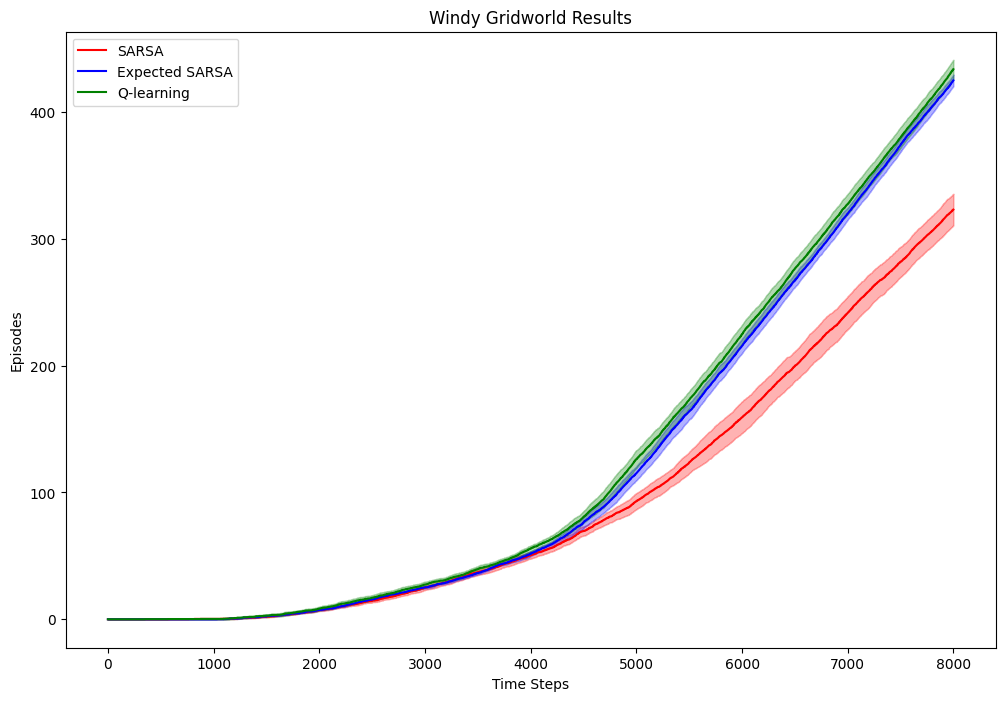

In [19]:
if __name__ == "__main__":
    # set randomness
    np.random.seed(1234)
    random.seed(1234)

    # trial number
    trial_num = 10
    # maximal time steps
    max_time_steps = 8000
    
    
    # run SARSA and Q Learning
    run_on_policy_td_control(trial_num, max_time_steps)

# Question 5 [5180 ONLY]
- Please refer to starter code from question 4 to help you get started. You will create your own TD(0) and Monte Carlo classes.
- We will continue with the original windy gridworld domain. 
- A fixed policy π will be specified to collect episodes.
- A certain number of “training” episodes N ∈ {1, 10, 50} will be collected.
- Each method being investigated ( On-policy TD(0), On-policy Monte-Carlo prediction) will learn to      estimate the state-value.
function using the N “training“ episodes, respectively.
- We then evaluate the distribution of learning targets each method experiences at a specified state S. In
this question, S is the initial state marked as S in the Example 6.5.
- To do so, you need to collect additional 100 “evaluation” episodes. Instead of using these to perform
further updates to the state-value function, we will instead evaluate the distribution of learning targets
V(S) based on the “evaluation” episodes. For example, TD(0) will experience a set of {R+ V(S′)} targets,
whereas Monte-Carlo will experience a set of {G} targets.
- Note that in practice you should pre-collect both the training and evaluation episodes for efficiency and to
ensure consistency while comparing between different methods.

In [9]:
class TD0(object):
    def __init__(self, env, alpha=0.1, gamma=0.9):
        # Initialize environment and parameters
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor

        # Initialize value function as a defaultdict of floats
        self.V = defaultdict(float)

    def learn(self, episodes, policy):
        # Learn value function from episodes using the given policy
        for episode in tqdm(episodes, desc="TD(0) Learning"):
            # Reset environment to start a new episode
            S, _ = self.env.reset()
            terminated = False
            while not terminated:
                # Select action based on the policy
                A = policy(S, self.V, self.env)
                
                # Take action and observe next state and reward
                S_prime, R, terminated = self.env.step(A)
                
                # Update value function using TD(0) update rule
                self.V[tuple(S)] += self.alpha * (R + self.gamma * self.V[tuple(S_prime)] - self.V[tuple(S)])
                
                # Move to the next state
                S = S_prime

    def evaluate_targets(self, eval_episodes, policy):
        # Evaluate targets for given evaluation episodes using the policy
        targets = []
        for episode in tqdm(eval_episodes, desc="TD(0) Evaluating Targets"):
            # Reset environment to start a new episode
            S, _ = self.env.reset()
            terminated = False
            while not terminated:
                # Select action based on the policy
                A = policy(S, self.V, self.env)
                
                # Take action and observe next state and reward
                S_prime, R, terminated = self.env.step(A)
                
                # Calculate target value and append to targets list
                targets.append(R + self.gamma * self.V[tuple(S_prime)])
                
                # Move to the next state
                S = S_prime
        return targets

In [10]:
class MonteCarlo(object):
    def __init__(self, env, gamma=0.9):
        # Initialize environment and parameters
        self.env = env
        self.gamma = gamma  # Discount factor

        # Initialize value function and returns
        self.V = defaultdict(float)  # Value function
        self.Returns = defaultdict(list)  # List of returns for each state

    def learn(self, episodes, policy):
        # Learn value function from episodes using the given policy
        for episode in tqdm(episodes, desc="Monte Carlo Learning"):
            # Reset environment to start a new episode
            s, _ = self.env.reset()
            terminated = False
            states_visited = []  # List to store states visited in the episode
            rewards = []  # List to store rewards received in the episode

            while not terminated:
                # Select action based on the policy
                A = policy(s, self.V, self.env)
                
                # Take action and observe next state and reward
                s_prime, r, terminated = self.env.step(A)
                
                # Append state and reward to lists
                states_visited.append(s)
                rewards.append(r)
                
                # Move to the next state
                s = s_prime

            # Initialize return
            G = 0
            # Calculate returns for each state visited in reverse order
            for t in reversed(range(len(states_visited))):
                G = self.gamma * G + rewards[t]
                s = states_visited[t]
                
                # Append return to the list of returns for the state
                self.Returns[tuple(s)].append(G)
                
                # Update value function as the mean of returns
                self.V[tuple(s)] = np.mean(self.Returns[tuple(s)])

    def evaluate_targets(self, eval_episodes, policy):
        # Evaluate targets for given evaluation episodes using the policy
        targets = []
        for episode in tqdm(eval_episodes, desc="Monte Carlo Evaluating Targets"):
            # Reset environment to start a new episode
            s, _ = self.env.reset()
            terminated = False
            states_visited = []  # List to store states visited in the episode
            rewards = []  # List to store rewards received in the episode

            while not terminated:
                # Select action based on the policy
                A = policy(s, self.V, self.env)
                
                # Take action and observe next state and reward
                s_prime, r, terminated = self.env.step(A)
                
                # Append state and reward to lists
                states_visited.append(s)
                rewards.append(r)
                
                # Move to the next state
                s = s_prime

            # Initialize return
            G = 0
            # Calculate returns for each state visited in reverse order
            for t in reversed(range(len(states_visited))):
                G = self.gamma * G + rewards[t]
                # Append return to the targets list
                targets.append(G)

        return targets

In [11]:
def epsilon_greedy_policy(state, V, env, epsilon=0.1):
    # Epsilon-greedy policy for action selection
    if np.random.rand() < epsilon:
        # Explore: choose a random action
        return random.choice(list(env.action_space.keys()))
    else:
        # Exploit: choose the best action based on value function
        best_actions = []
        best_value = -float('inf')
        
        # Iterate over all possible actions
        for act in env.action_space:
            # Calculate the next state based on the current state and action
            next_state = np.array(state) + env.action_space[act] + np.array([env.wind[state[1]], 0])
            
            # Ensure the next state is within the grid boundaries
            next_state[0] = max(0, min(next_state[0], 6))
            next_state[1] = max(0, min(next_state[1], 9))
            
            # Get the value of the next state from the value function
            value = V[tuple(next_state)]
            
            # Update the best actions list based on the value
            if value > best_value:
                best_value = value
                best_actions = [act]
            elif value == best_value:
                best_actions.append(act)
        
        # Return a random action from the best actions
        return random.choice(best_actions if best_actions else list(env.action_space.keys()))

In [12]:
def generate_episodes(env, policy, num_episodes):
    # Initialize list to store episodes
    episodes = []
    
    # Loop to generate the specified number of episodes
    for _ in tqdm(range(num_episodes), desc="Generating Episodes"):
        episode = []  # Initialize list to store the current episode
        state, terminated = env.reset()  # Reset environment to start a new episode
        
        # Loop until the episode terminates
        while not terminated:
            # Select action based on the policy
            action = policy(state, {})  # Empty dictionary for V during episode generation
            
            # Take action and observe next state and reward
            next_state, reward, terminated = env.step(action)
            
            # Append state, action, and reward to the episode list
            episode.append((state, action, reward))
            
            # Move to the next state
            state = next_state
        
        # Append the generated episode to the episodes list
        episodes.append(episode)
    
    return episodes

In [13]:
def dynamic_programming(env, theta, gamma):
    # Initialize value function as a defaultdict of floats
    V = defaultdict(float)
    delta = float('inf')  # Initialize delta to a large value

    # Loop until the change in value function is less than the threshold theta
    while delta >= theta:
        delta = 0  # Reset delta for the current iteration
        # Iterate over all states in the state space
        for s in env.state_space:
            v = V[tuple(s)]  # Store the current value of the state
            action_sum = 0  # Initialize the sum of action values for the state
            # Iterate over all actions in the action space
            for a in env.action_space:
                prob = 1.0 / len(env.action_space)  # Assume uniform probability for actions
                # Calculate the next state based on the current state and action
                next_state = np.array(s) + env.action_space[a] + np.array([env.wind[s[1]], 0])
                # Ensure the next state is within the grid boundaries
                next_state[0] = max(0, min(next_state[0], 6))
                next_state[1] = max(0, min(next_state[1], 9))
                # Calculate the reward and next state value
                action_sum += prob * (-1.0 + gamma * V[tuple(next_state)] if next_state.tolist() != env.goal_state else 1.0)

            # Update the value function for the state
            V[tuple(s)] = action_sum
            # Update delta to the maximum change in value function
            delta = max(delta, abs(v - V[tuple(s)]))
    
    return V  # Return the updated value function

In [14]:
def run_on_policy_mc_td_epsilon_greedy_windy_gridworld():
    # Enable or disable king move and no move actions
    enable_king_move_actions = False
    enable_no_move_actions = False

    # Initialize the WindyGridWorld environment
    env = WindyGridWorld(enable_king_move=enable_king_move_actions,
                         enable_no_move=enable_no_move_actions)
    
    # Define the number of training episodes for different runs
    train_Ns = [1, 10, 50]
    # Define the methods to be used (TD0 and MonteCarlo)
    methods = [TD0, MonteCarlo]
    # Number of evaluation episodes
    eval_episodes_num = 100
    # Threshold for dynamic programming convergence
    theta = 0.0001
    # Discount factor
    gamma = 0.9

    # Generate evaluation episodes using a random policy
    eval_episodes = generate_episodes(env, lambda s, V: random.choice(list(env.action_space.keys())), eval_episodes_num)  # Random policy for eval

    # Loop over each method (TD0 and MonteCarlo)
    for method_class in methods:
        # Loop over each training episode count
        for N in train_Ns:
            # Initialize the method (TD0 or MonteCarlo)
            method = method_class(env)
            # Generate training episodes using a random policy
            train_episodes = generate_episodes(env, lambda s, V: random.choice(list(env.action_space.keys())), N)  # Random for training data generation

            print(f"Running {method_class.__name__} with N={N}")
            # Learn the value function using the generated training episodes and epsilon-greedy policy
            method.learn(train_episodes, lambda s, V, env=env: epsilon_greedy_policy(s, V, env))  # Pass partial function
            # Evaluate the targets using the generated evaluation episodes and random policy
            targets = method.evaluate_targets(eval_episodes, lambda s, V, env=env: random.choice(list(env.action_space.keys())))

            # Calculate the true value using dynamic programming
            true_value = dynamic_programming(env, theta, gamma)[tuple(env.start_state)]

            # Plot the histogram of the learning targets
            plt.figure()
            plt.hist(targets, bins=20, label="Learning Targets")
            plt.axvline(true_value, color='red', linestyle='dashed', linewidth=1, label=f"True Value ({true_value:.2f})")
            plt.xlabel("Target Values")
            plt.ylabel("Frequency")
            plt.title(f"{method_class.__name__} Targets (N={N}, Start State)")
            plt.legend()
            plt.show()

Generating Episodes: 100%|██████████| 1/1 [00:00<00:00, 67.81it/s]


Running TD0 with N=1


TD(0) Evaluating Targets: 100%|██████████| 100/100 [00:02<00:00, 37.35it/s]


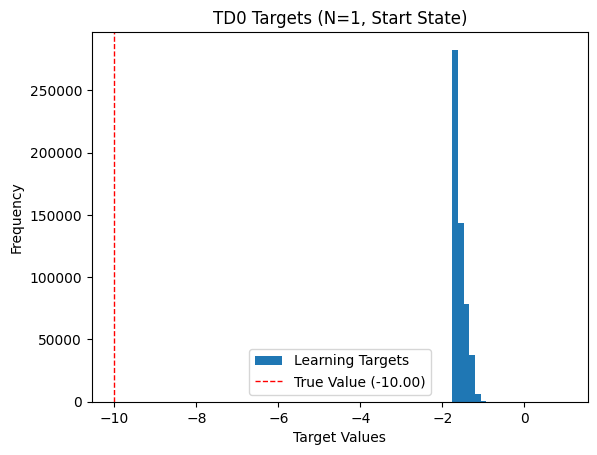

Generating Episodes: 100%|██████████| 10/10 [00:00<00:00, 36.92it/s]


Running TD0 with N=10


TD(0) Evaluating Targets: 100%|██████████| 100/100 [00:02<00:00, 35.26it/s]


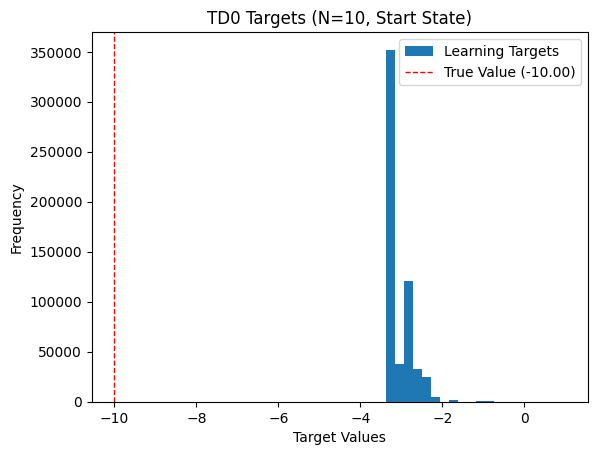

Generating Episodes: 100%|██████████| 50/50 [00:01<00:00, 25.56it/s]


Running TD0 with N=50


TD(0) Evaluating Targets: 100%|██████████| 100/100 [00:03<00:00, 31.53it/s]


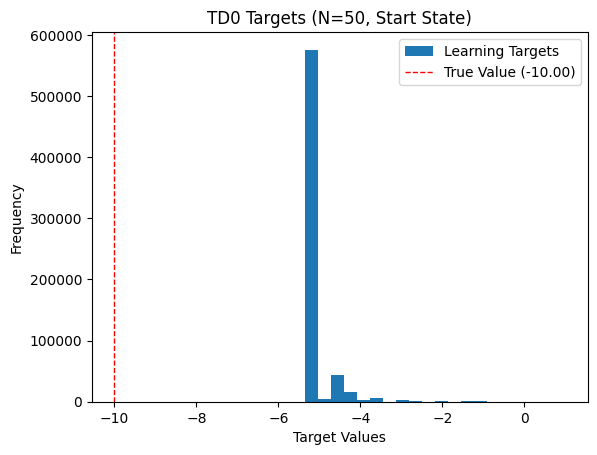

Generating Episodes: 100%|██████████| 1/1 [00:00<00:00, 317.56it/s]


Running MonteCarlo with N=1


Monte Carlo Evaluating Targets: 100%|██████████| 100/100 [00:03<00:00, 29.32it/s]


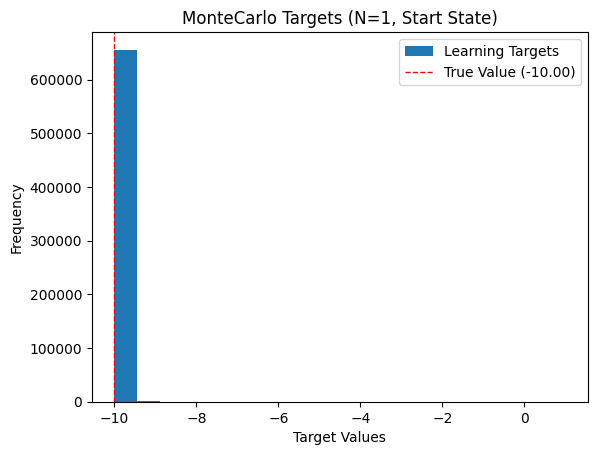

Generating Episodes: 100%|██████████| 10/10 [00:00<00:00, 42.34it/s]


Running MonteCarlo with N=10


Monte Carlo Evaluating Targets: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


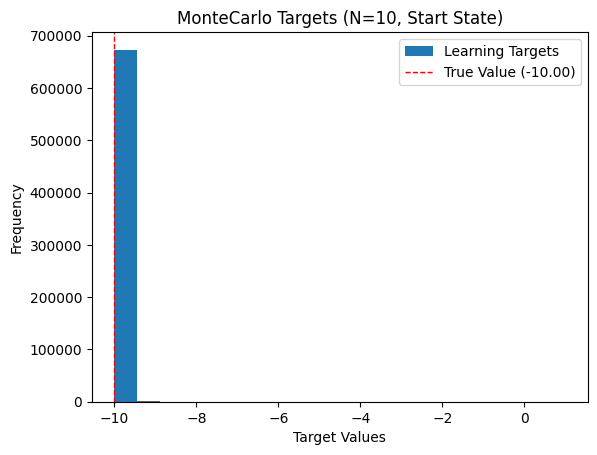

Generating Episodes: 100%|██████████| 50/50 [00:01<00:00, 43.14it/s]


Running MonteCarlo with N=50


Monte Carlo Evaluating Targets: 100%|██████████| 100/100 [00:03<00:00, 31.32it/s]


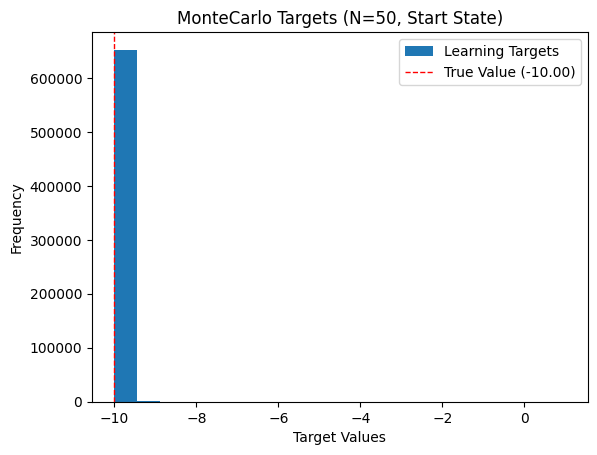

In [15]:
if __name__ == "__main__":
    np.random.seed(1234)
    random.seed(1234)

    run_on_policy_mc_td_epsilon_greedy_windy_gridworld()